# ELE510 Project - Hand Gesture Detection

## Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import codecs
import json

## Loading and testing data

In [2]:
# Adding all annotation files to a list
files = []
for file in os.listdir("data"):
    if file.endswith(".json"):
        files.append(os.path.join("data", file))
        
# Exporting json data from file to dictionary
class_names = [
       'call',
       'dislike',
       'fist',
       'four',
       'like',
       'mute',
       'ok',
       'one',
       'palm',
       'peace',
       'peace_inverted',
       'rock',
       'stop',
       'stop_inverted',
       'three',
       'three2',
       'two_up',
       'two_up_inverted']

data = {}

for file in files:
    class_annotations = {}
    st = file.find("data")
    ed = file.find(".json")
    current_class = file[st+5:ed]
    with codecs.open(file,'r','utf-8') as f: 
        annotations = json.load(f)
        for annotation in annotations:
            class_annotations[annotation] = annotations[annotation]
    data[current_class] = class_annotations

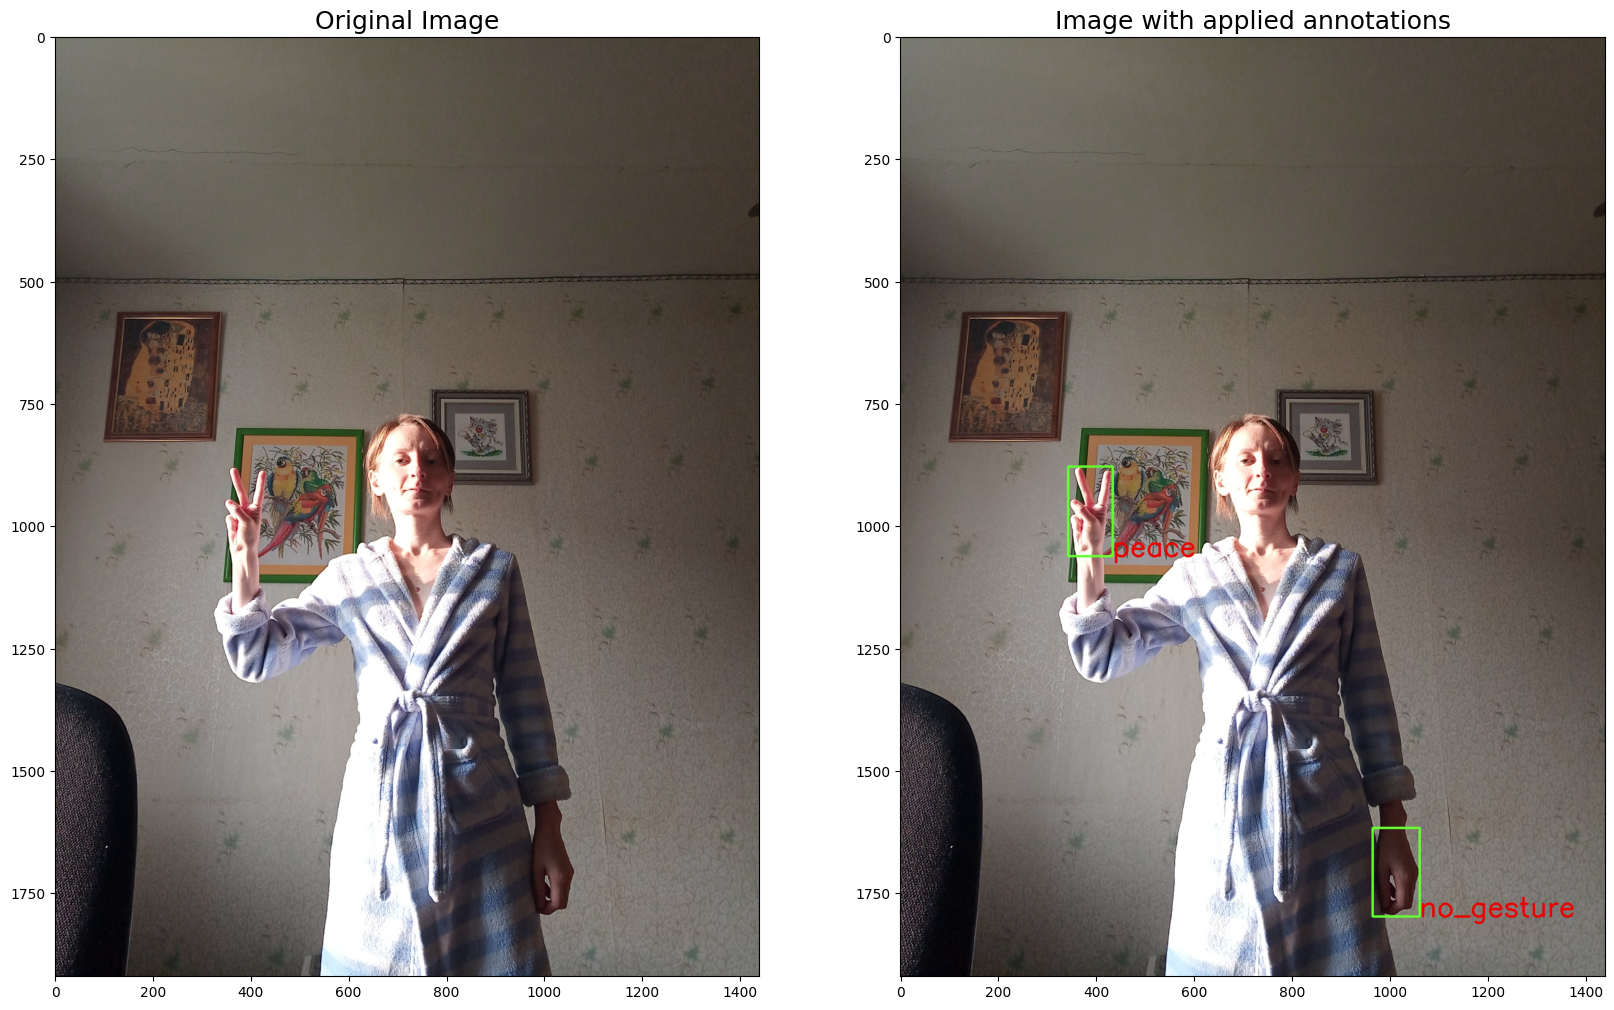

In [3]:
# Testing data in RGB format
image_name = '01197ad5-3116-4b67-9871-f533cdd21d5a'
im = cv2.imread('./images/peace/' + image_name + '.jpg')[...,::-1]

# Applying image data
im_ann = im.copy()
im_data = data['peace'][image_name]
h, w = im_ann.shape[0], im_ann.shape[1]
iteration = 0
for bbox in im_data['bboxes']:
    start_point = (int(w*bbox[0]) , int(h*bbox[1]))
    end_point = (int(start_point[0]+(w*bbox[2])), int(start_point[1]+(h*bbox[3])))
    im_ann = cv2.rectangle(im_ann, start_point, end_point, color = (102,255,51), thickness = 3)
    cv2.putText(im_ann, im_data['labels'][iteration], (end_point[0], end_point[1]), cv2.FONT_HERSHEY_SIMPLEX, w / 780, (237, 0, 0), 3)
    iteration += 1

# Plot images
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title('Original Image', fontsize=18)
plt.imshow(im)
plt.subplot(122)
plt.title('Image with applied annotations', fontsize=18)
plt.imshow(im_ann)
plt.show()